In [41]:
import pandas as pd
import html
import re
import gensim
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize

In [59]:
df = pd.read_csv("./extracted_data/compiled/telegrams_with_extracted_receiver_sender.csv")
df = df.drop([165, 273]) # 2 rows with incorrect dates
df['body'] = df['body'].astype(str)
df['datetime'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
start_date = '1945-08-14'
end_date = '1953-07-30'
date_range = (df["datetime"] > start_date) & (df['datetime'] <= end_date)
df = df.loc[date_range] # choose relevant telegrams from the Korean war
df.head()

,Unnamed: 0,title,date,body,creators,subjects,recipient,sender,datetime
0,0,Telegram from Aleksandr Vasilevsky to Stalin,19450818,18.8.45Moscow. Personally to Cde. StalinCopy: ...,"['Vasilevsky, Aleksandr Mikhaylovich']","['World War, 1939-1945--Campaigns--Japan--Hokk...",Stalin,Aleksandr Vasilevsky,1945-08-18
1,1,Cable from Aleksandr Vasilevsky to Stalin,19450820,Moscow. Cde. StalinCopy: General Staff Cde. An...,"['Vasilevsky, Aleksandr Mikhaylovich']","['Kuril Islands', 'World War, 1939-1945--Campa...",Stalin,Aleksandr Vasilevsky,1945-08-20
2,2,"Cable No. 121973, Meretskov and Shytkov to Cde...",19470512,[handwritten at the top: to Cde. StalinI think...,"['Shtykov, Terentiĭ Fomich, 1907-1964']",['Korea (North)--Foreign relations--Soviet Uni...,Stalin,Meretskov,1947-05-12
3,3,"Telephone Message via VCh, I. Stalin to Kim Il...",19481012,Telephone message via VChCorrected text of ate...,"['Stalin, Joseph, 1879-1953']",['Korea (North)--Foreign relations--Soviet Uni...,Kim Il Sung,I. Stalin,1948-10-12
4,4,"Telegram, Shtemenko and Vasilevsky to Stalin",19490420,UNCLASSIFIEDCopy Nº 1[handwritten: from Cdes. ...,"['Vasilevsky, Aleksandr Mikhaylovich', 'Shteme...","['38th Parallel', 'Korea (North)--Foreign rela...",Stalin,Shtemenko,1949-04-20


1945 - 1947: Initial Sentiments right after Japan surrendered

1948 - 1949: South Korea established

1950 - 1951: Korean War

1952 - 1953: Aftermath

In [55]:
def parse_and_train(given_df):
    long_sentences = []
    for index, row in given_df.iterrows():
        if len(row.body) > 0:
            sentences = row.body.split(".")
            for sentence in sentences:
                word_tokens = word_tokenize(sentence)
                filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
                final_sentence = " ".join(filtered_sentence)
                if len(final_sentence) > 4:
                    long_sentences.append(final_sentence)

    for sentence in long_sentences:
        yield gensim.utils.simple_preprocess (sentence)

In [63]:
start_date = '1945-08-14'
end_date = '1948-07-31'
date_range = (df["datetime"] > start_date) & (df['datetime'] <= end_date)
df_1 = df.loc[date_range] 
print("1945 - 1947: Initial Sentiments right after Japan surrendered\nTelegrams available: ", len(df_1))

documents = []
documents.extend(list(parse_and_train(df_1)))

1945 - 1947: Initial Sentiments right after Japan surrendered
Telegrams available:  3


In [45]:
model = gensim.models.Word2Vec (documents, vector_size=150, window=5, min_count=2, workers=4)
model.train(documents,total_examples=len(documents),epochs=10)

(6523, 13270)

In [38]:
# search for similar words in the document
w1 = "moscow"
model.wv.most_similar(positive=w1)

[('cable', 0.19193486869335175),
 ('left', 0.18191255629062653),
 ('cities', 0.15997406840324402),
 ('bulganin', 0.15869741141796112),
 ('simultaneously', 0.1477995216846466),
 ('think', 0.14482909440994263),
 ('immediate', 0.1415518969297409),
 ('aforesaid', 0.13406550884246826),
 ('turned', 0.13273614645004272),
 ('boli', 0.11650580912828445)]

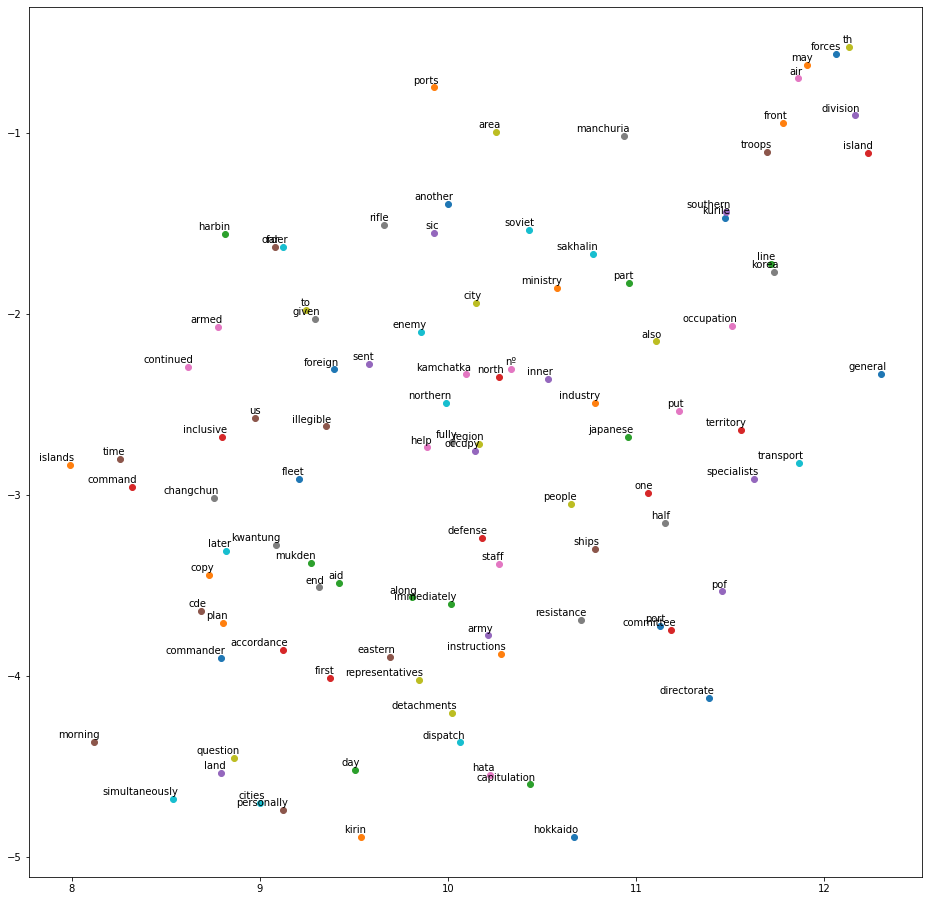

In [49]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    
#     fyi: to test specific labels instead of all the words in the vocab: 
    # labels = ['dprk', 'minister', 'president', 'korean', 'pyongyangon', 'comrade']
    # tokens = []
    # for label in labels: 
    #     tokens.append(model.wv[label])

    labels = []
    tokens = []
    

    # to speed up the process, let's limit to the first 100 elements
    count = 0
    for word in list(model.wv.key_to_index):
        if count < 100:
            # store the word embeddings of the words 
            tokens.append(model.wv[word])
            # keep track of the labels too so that we can plot it in the graph below
            labels.append(word)
            count = count+1

    # define the parameters of the tsne model
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    
    # for the embeddings of our tokes to the tsne model
    new_values = tsne_model.fit_transform(tokens)


    # Now let's plot the tsne projects for each of the tokens in 2D
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(model)

1948 - 1949: South Korea established
Telegrams available:  8


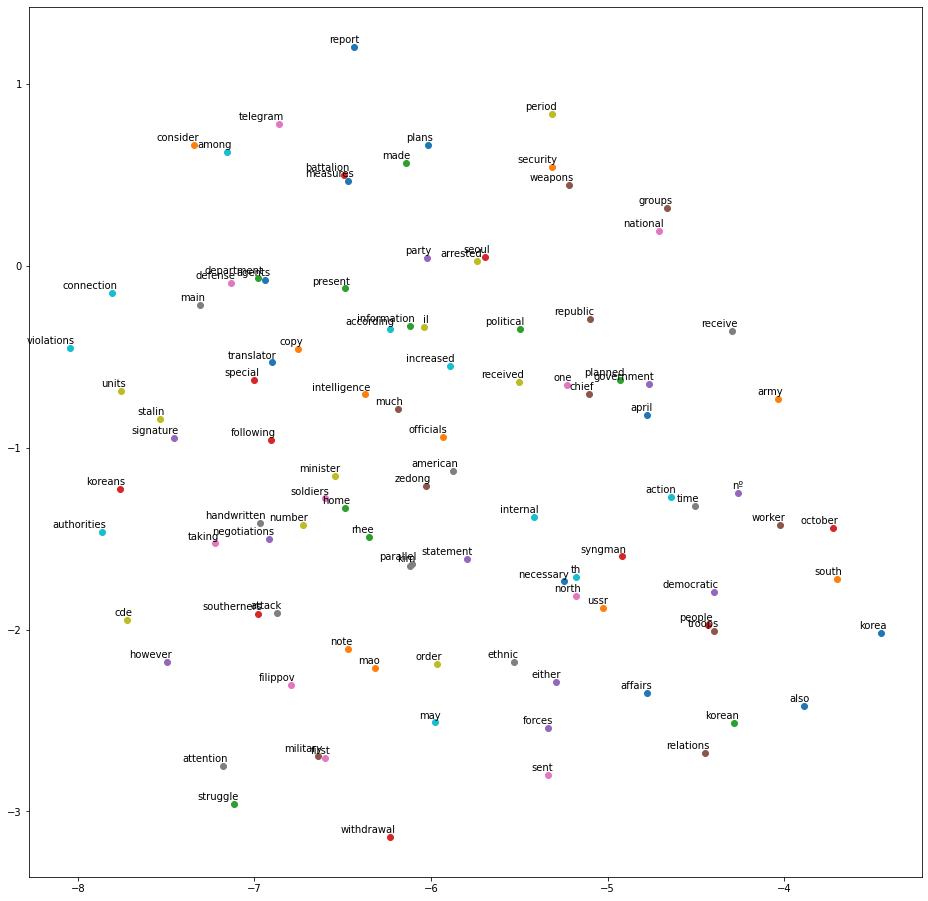

In [64]:
start_date = '1948-08-01'
end_date = '1949-12-31'
date_range = (df["datetime"] > start_date) & (df['datetime'] <= end_date)
df_2 = df.loc[date_range] # choose relevant telegrams from the Korean war
df_2.head()
print("1948 - 1949: South Korea established\nTelegrams available: ", len(df_2))

documents = []
documents.extend(list(parse_and_train(df_2)))
model = gensim.models.Word2Vec (documents, vector_size=150, window=5, min_count=2, workers=4)
model.train(documents,total_examples=len(documents),epochs=10)
%matplotlib inline
tsne_plot(model)

1950 - 1951: Korean War
Telegrams available:  122


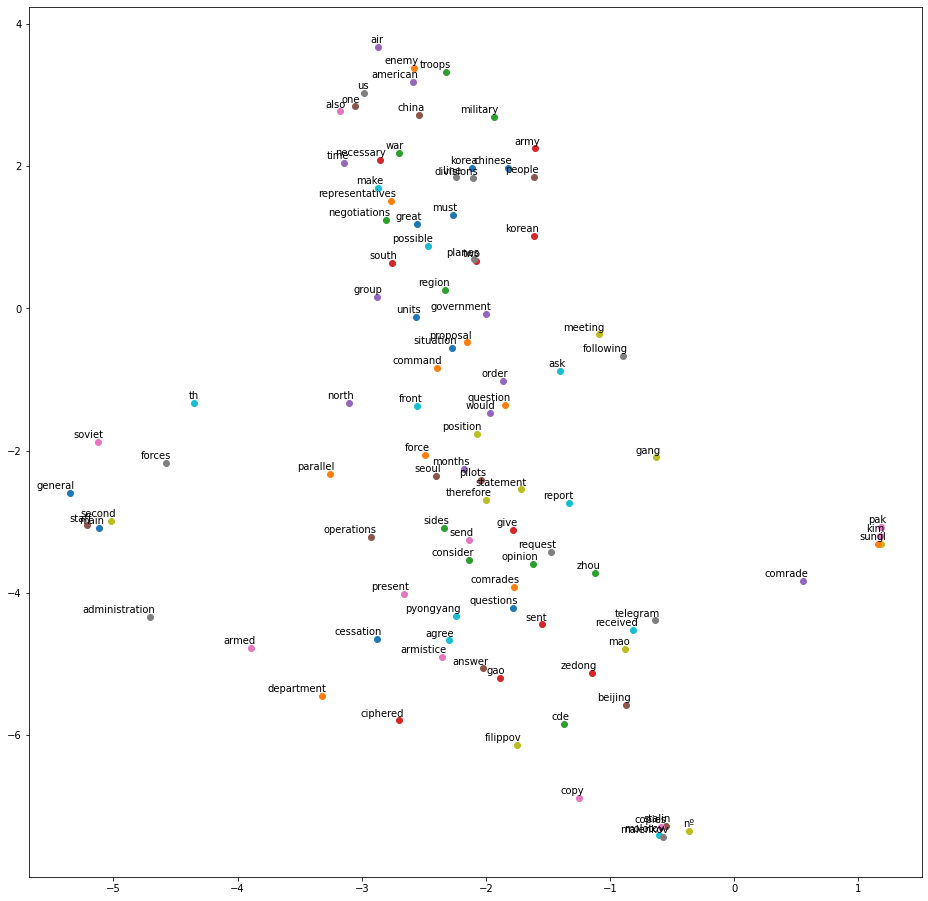

In [65]:
start_date = '1950-01-01'
end_date = '1951-12-31'
date_range = (df["datetime"] > start_date) & (df['datetime'] <= end_date)
df_3 = df.loc[date_range] # choose relevant telegrams from the Korean war
print("1950 - 1951: Korean War\nTelegrams available: ", len(df_3))

documents = []
documents.extend(list(parse_and_train(df_3)))
model = gensim.models.Word2Vec (documents, vector_size=150, window=5, min_count=2, workers=4)
model.train(documents,total_examples=len(documents),epochs=10)
tsne_plot(model)

1952 - 1953: Aftermath
Telegrams available:  7


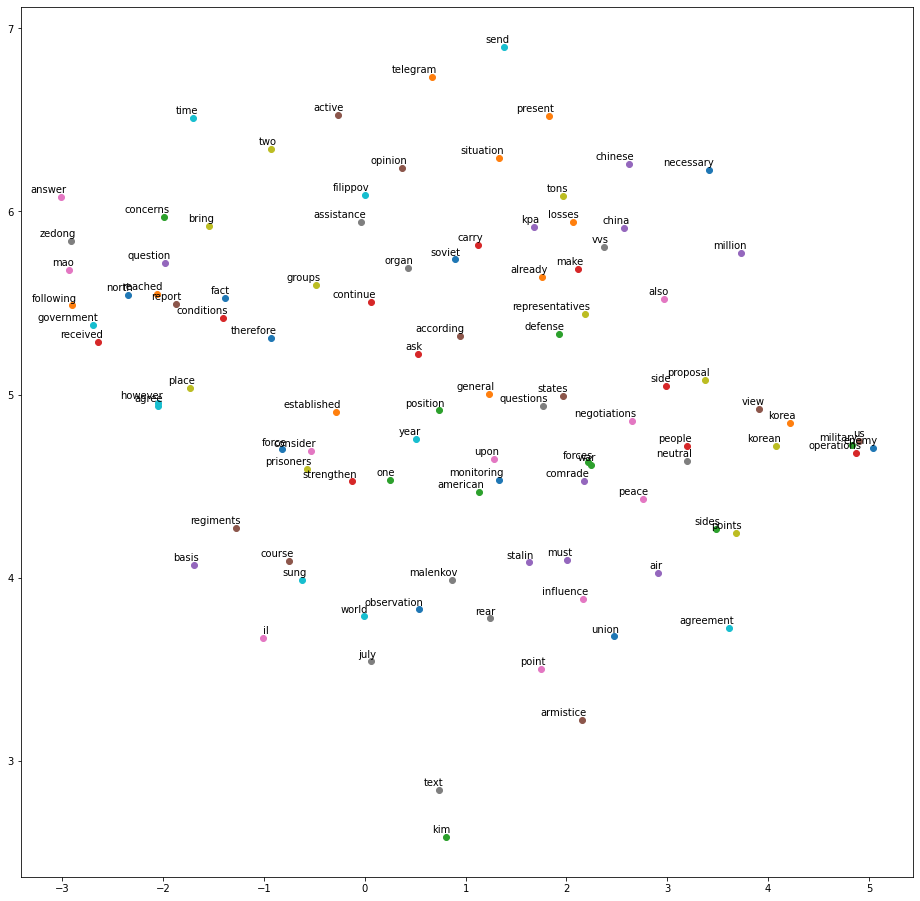

In [66]:
start_date = '1952-01-01'
end_date = '1953-07-30'
date_range = (df["datetime"] > start_date) & (df['datetime'] <= end_date)
df_4 = df.loc[date_range] # choose relevant telegrams from the Korean war
print("1952 - 1953: Aftermath\nTelegrams available: ", len(df_4))

documents = []
documents.extend(list(parse_and_train(df_4)))
model = gensim.models.Word2Vec (documents, vector_size=150, window=5, min_count=2, workers=4)
model.train(documents,total_examples=len(documents),epochs=10)
tsne_plot(model)